# Elo Clean

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pendulum
import warnings

warnings.filterwarnings('ignore')
import utils

In [56]:
class Game:
    def __init__(self, dt, home, away, home_mov, home_elo=None, away_elo=None,homefield=100,k=22):
        self.dt = dt
        self.home = home
        self.away = away
        self.home_mov = home_mov
        self.home_elo = home_elo
        self.away_elo = away_elo
        self.homefield = homefield
        self.k = k
    
    def _get_q(self, elo):
        q = 10 ** (elo / 400)
        
        return q
    
    def get_home_expectation(self):
        home_elo = self.home_elo + self.homefield
        
        expectation = (
            self._get_q(home_elo) / (self._get_q(self.away_elo) + self._get_q(home_elo))
        )
        
        return expectation
    
    def UpdateElo(self):
        if self.get_home_expectation() >= 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
        
        elif self.get_home_expectation() >= 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
            
def clean_br_date(input_string):
    day_of_week, raw_month, raw_date, raw_year = input_string.split(' ')
    if raw_month == 'Dec':
        month = 12
    elif raw_month == 'Jan':
        month = 1
    elif raw_month == 'Feb':
        month = 2
    elif raw_month == 'Mar':
        month = 3
    elif raw_month == 'Apr':
        month = 4
    elif raw_month == 'May':
        month = 5
        
    year = int(raw_year)
    day = int(raw_date)
    
    return pendulum.Date(year, month, day)

def get_elo(team, elos):
    elo = (
        elos
        .query(f'team == "{team}"')
        .sort_values(by='dt', ascending=False)
        .elo
        .tolist()
        [0]
    )
    
    return elo

In [65]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

In [66]:
games = (
    df
    .query('game_number <= 82')
    .query('season >= "2008-09"')
    .query('home_away == "Home"')
    [['season', 'dt', 'team', 'opponent', 'mov']]
    .rename(
        columns={
            'team': 'home',
            'opponent': 'away',
            'mov': 'home_mov'
        }
    )
    .sort_values(
        by=['season', 'dt', 'home']
    )
    .assign(
        dt = lambda x: x['dt'].apply(utils.clean_date)
    )
)

games

,season,dt,home,away,home_mov
2725,2008-09,2008-10-28,Boston,Cleveland,5
2903,2008-09,2008-10-28,Chicago,Milwaukee,13
3705,2008-09,2008-10-28,LALakers,Portland,20
3278,2008-09,2008-10-29,Detroit,Indiana,6
3364,2008-09,2008-10-29,GoldenState,NewOrleans,-5
...,...,...,...,...,...
38583,2022-23,2022-12-11,Houston,Milwaukee,5
38823,2022-23,2022-12-11,NewOrleans,Phoenix,5
38850,2022-23,2022-12-11,NewYork,Sacramento,13
38904,2022-23,2022-12-11,Orlando,Toronto,12


In [67]:
teams = games.home.unique().tolist()

elos = pd.DataFrame(
    {
        'team': teams,
        'elo': np.repeat(1500, len(teams)),
        'dt': np.repeat(pendulum.Date(2007,10,31), len(teams))
    }
)

## Run Elos

In [68]:
for raw in games.to_dict('records'):
    game = Game(home=raw['home'], away=raw['away'], dt=raw['dt'], home_mov=raw['home_mov'])
    game.home_elo = get_elo(game.home, elos)
    game.away_elo = get_elo(game.away, elos)
    
   
    game.UpdateElo()
    home_update = {
        'team': game.home,
        'elo': game.home_elo,
        'dt': game.dt
    }
    
    elos = elos.append(home_update, ignore_index=True)

    away_update = {
        'team': game.away,
        'elo': game.away_elo,
        'dt': game.dt
    }
    
    elos = elos.append(away_update, ignore_index=True)

## Results

In [69]:
dates = elos.dt.unique().tolist()

final = (
    pd.DataFrame({'dt': dates})
    .merge(
        pd.DataFrame({'team': teams}),
        how='cross'
    )
    .assign(
        dummy='dummy'
    )
    .merge(
        elos,
        on=['dt', 'team'],
        how='left'
    )
    .assign(
        elo = lambda x: x.groupby('team')['elo'].transform(lambda s: s.ffill())
    )
    .merge(
        (
            games
            [['season', 'dt']]
            .drop_duplicates()
        ),
        on='dt',
        how='left'
    )
)

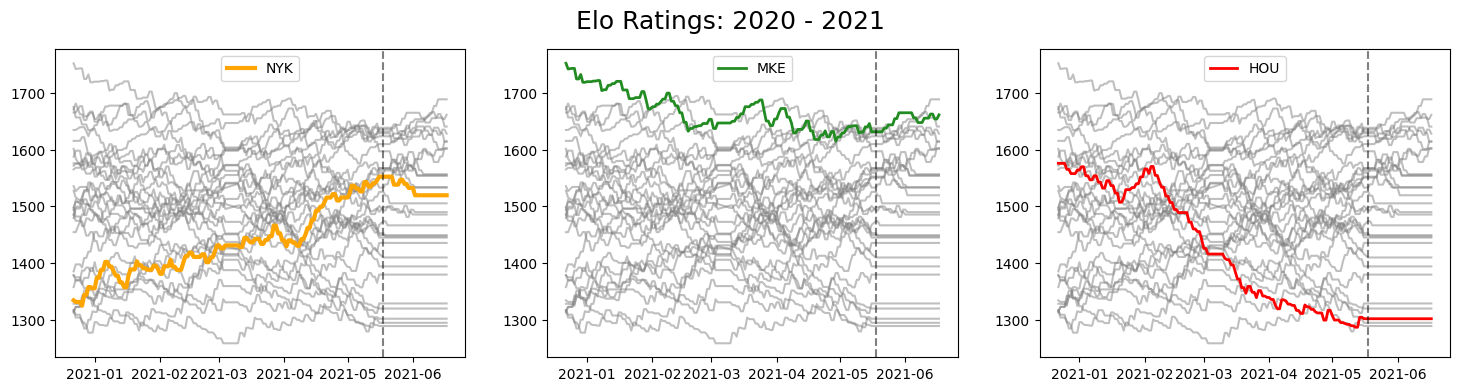

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

team = 'NewYork'

(
    final
    .query(f'team != "{team}"')
    .query('season == "2020-21"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax1
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='Orange',
        ax=ax1,
        label='NYK',
        lw=3
    )
)

team = 'Milwaukee'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax2
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='forestgreen',
        ax=ax2,
        label='MKE',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')

team = 'Houston'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax3
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='red',
        ax=ax3,
        label='HOU',
        lw=2
    )
)

ax1.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax2.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax3.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle('Elo Ratings: 2020 - 2021', size=18)
plt.show()

## Is It Good?